In [ ]:
!pip install yfinance

# Test for cointegration

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from math import floor
plt.style.use('seaborn-whitegrid')
from sklearn import linear_model
pd.set_option("display.max_rows", None)

In [ ]:
# set the start and end dates
start_date = '2002-01-01'
end_date = '2023-03-03'

# download the historical prices for the two stocks
BBH = yf.download('BBH', start=start_date, end=end_date)
IBB = yf.download('IBB', start=start_date, end=end_date)

# Drop unnecessary columns and rename
BBH = BBH.drop(['Open', 'High', 'Low', 'Close'], axis=1)
IBB = IBB.drop(['Open', 'High', 'Low', 'Close'], axis=1)

BBH = BBH.rename(columns={"Adj Close": "Close/Last"})
IBB = IBB.rename(columns={"Adj Close": "Close/Last"})

# Merge and Clean
price_data = pd.merge(BBH, IBB, on='Date', how='inner',suffixes=('_BBH','_IBB'))
price_data = price_data.reset_index()
price_data.loc[:,'Date'] = pd.to_datetime(price_data['Date'])
price_data.index = price_data.loc[:,'Date']
price_data.sort_index(inplace=True)
price_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close/Last_BBH,Volume_BBH,Close/Last_IBB,Volume_IBB
Date,,,,,
2002-01-02,2002-01-02,16.274073,3126600,28.669762,1478700
2002-01-03,2002-01-03,15.844004,5457000,28.315018,908400
2002-01-04,2002-01-04,16.176840,10707600,28.556892,3177900
2002-01-07,2002-01-07,15.962423,3132900,28.040894,1851600
2002-01-08,2002-01-08,16.028494,2393400,28.169897,141300


In [ ]:
#visualize pair
price = price_data[['Close/Last_BBH','Close/Last_IBB']].copy()

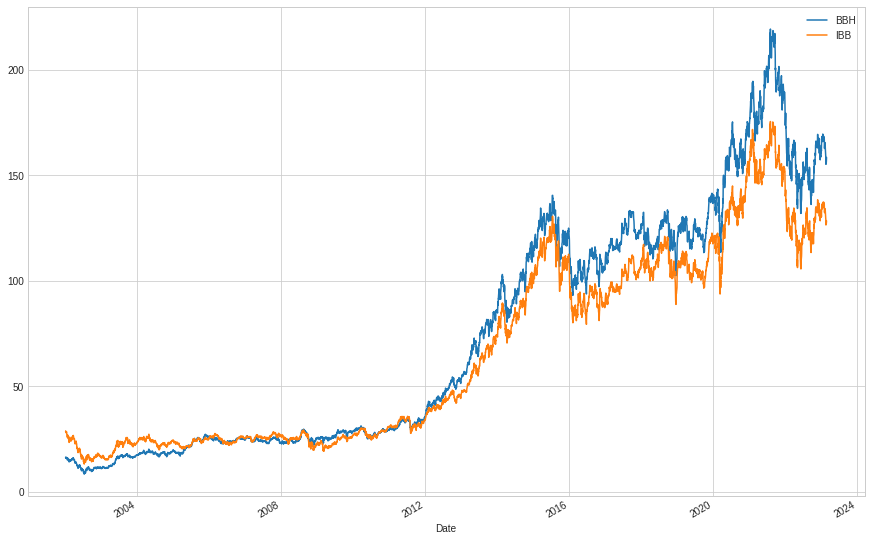

In [ ]:
import datetime as dt
price.columns = ('BBH','IBB')
lp = np.log(price)
price.plot(figsize = (15,10))
plt.show()

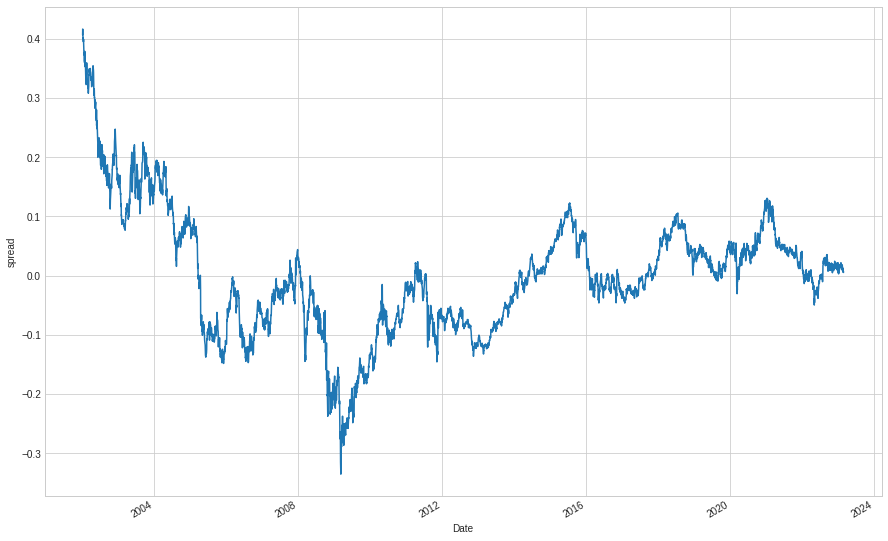

In [ ]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    x_constant.columns = x_constant.columns.astype(str)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

x = lp['BBH']
y = lp['IBB']


spread = reg(x,y)

# plot the spread series
spread.plot(figsize =(15,10))
plt.ylabel('spread')
plt.show()

In [ ]:
adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -4.06
	1%: -3.432
	5%: -2.862
	10%: -2.567
p-value: 0.001


# Testing

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total return: -0.998881886776514
Annualized return: -0.3857606631103031
Sharpe ratio: 0.2969332565772392


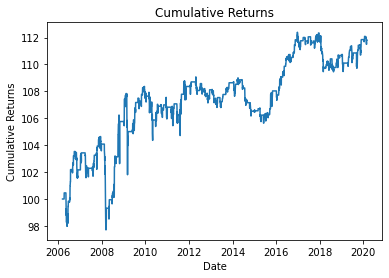

"\n# plot the daily returns histogram and density\nfig, ax = plt.subplots(1, 2, figsize=(10, 5))\nax[0].hist(portfolio['Return'], bins=50, density=True, alpha=0.5, color='b')\nax[0].set_title('Daily Returns Histogram')\nax[0].set_xlabel('Return')\nax[0].set_ylabel('Frequency')\nsns.kdeplot(portfolio['Return'], ax=ax[1], color='b', legend=False)\nax[1].set_title('Daily Returns Density')\nax[1].set_xlabel('Return')\nax[1].set_ylabel('Density')\nplt.tight_layout()\nplt.show()\n"

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt


# set the start and end dates for the backtest
start_date = '2006-01-01'
end_date = '2020-03-03'

# download the historical prices for the two stocks
stock1 = yf.download('BBH', start=start_date, end=end_date)
stock2 = yf.download('IBB', start=start_date, end=end_date)

# calculate the spread between the two stocks
spread = stock1['Adj Close'] - stock2['Adj Close']
# mean_spread = np.mean(spread)
# std_spread = np.std(spread)

mean_spread = []
std_spread = []
lookback = 50
for i in range(lookback, len(stock1)):
  mean_spread.append(np.mean(spread[i-lookback:i]))
  std_spread.append(np.std(spread[i-lookback:i]))



# initialize the portfolio with zero holdings
portfolio = pd.DataFrame(index=spread.index, columns=['Stock1', 'Stock2', 'Value', 'Return'])

# initialize the cash balance with $100,000
cash = 100

# loop through each trading day and execute trades based on the trading signal
long_signal = []
short_signal = []
holding = 1
endHold = 0
spread_zscores = []
portfolio['Stock1'][lookback-1] = 0
portfolio['Stock2'][lookback-1] = 0
values = []
stock1_shares = 0
stock2_shares = 0
for i in range(lookback, len(spread)):
  # create a trading signal based on the spread
    values.append(stock1_shares * stock1.iloc[i]['Adj Close'] + stock2_shares * stock2.iloc[i]['Adj Close'] + cash)
    long_signal.append(spread[i] < (mean_spread[i - lookback] - 1.5 * std_spread[i - lookback]))
    short_signal.append(spread[i] > (mean_spread[i - lookback] + 1.5 * std_spread[i - lookback]))
    spread_zscores.append((spread[i] - mean_spread[i - lookback])/std_spread[i - lookback])
    if endHold > i:
      portfolio['Stock1'][i] = portfolio['Stock1'][i-1]
      portfolio['Stock2'][i] = portfolio['Stock2'][i-1]
      continue
    if i == endHold:
      cash = cash + stock1_shares * stock1['Adj Close'][i] + stock2_shares * stock2['Adj Close'][i]
      stock1_shares = 0
      stock2_shares = 0
    if long_signal[i - lookback]:
        # buy stock1 and sell stock2
        stock1_price = stock1['Adj Close'][i]
        stock2_price = stock2['Adj Close'][i]
        stock1_shares = cash / 2 / stock1_price
        stock2_shares = - cash / 2 / stock2_price
        portfolio['Stock1'][i] = stock1_shares
        portfolio['Stock2'][i] = stock2_shares
        cash = cash - stock1_shares * stock1_price - stock2_shares * stock2_price
        endHold = i + holding
    elif short_signal[i - lookback]:
        # sell stock1 and buy stock2
        stock1_price = stock1['Adj Close'][i]
        stock2_price = stock2['Adj Close'][i]
        stock1_shares = - cash / 2 / stock1_price
        stock2_shares = cash / 2 / stock2_price
        portfolio['Stock1'][i] = stock1_shares
        portfolio['Stock2'][i] = stock2_shares
        cash = cash - stock1_shares * stock1_price - stock2_shares * stock2_price
        endHold = i + holding
    else:
        # do nothing
        portfolio['Stock1'][i] = portfolio['Stock1'][i-1]
        portfolio['Stock2'][i] = portfolio['Stock2'][i-1]


# calculate the daily portfolio value
portfolio = portfolio.iloc[lookback:, :].copy()
portfolio['Value'] = values
# portfolio['Value'] = portfolio['Stock1'] * stock1['Adj Close'] + portfolio['Stock2'] * stock2['Adj Close'] + cash

# calculate the daily returns
portfolio['Return'] = portfolio['Value'].pct_change()

# print the backtest results
print('Total return:', (portfolio['Value'][-1] - 100000) / 100000)
print('Annualized return:', (portfolio['Value'][-1] / 100000) ** (252 / len(portfolio)) - 1)
print('Sharpe ratio:', np.sqrt(252) * np.mean(portfolio['Return']) / np.std(portfolio['Return']))

# plot the cumulative returns
# plt.plot(portfolio['Value'] / 100000 - 1)
plt.plot(portfolio['Value'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

'''
# plot the daily returns histogram and density
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(portfolio['Return'], bins=50, density=True, alpha=0.5, color='b')
ax[0].set_title('Daily Returns Histogram')
ax[0].set_xlabel('Return')
ax[0].set_ylabel('Frequency')
sns.kdeplot(portfolio['Return'], ax=ax[1], color='b', legend=False)
ax[1].set_title('Daily Returns Density')
ax[1].set_xlabel('Return')
ax[1].set_ylabel('Density')
plt.tight_layout()
plt.show()
'''

In [ ]:
#portfolio['Value'] = portfolio['Stock1'] * stock1['Adj Close'] + portfolio['Stock2'] * stock2['Adj Close'] + cash

print(portfolio['Value'][-1000])
print(portfolio['Return'][-1000])


108.95684786013547
0.0


In [ ]:
df_meta = portfolio.copy()
df_meta['Spread Z Scores'] = spread_zscores
df_meta['Long'] = long_signal
df_meta['Short'] = short_signal
signals = []
for i in range(len(df_meta)):
  if df_meta.iloc[i]['Long'] == True:
    signals.append(1)
  elif df_meta.iloc[i]['Short'] == True:
    signals.append(-1)
  else:
    signals.append(0)

df_meta['Signals'] = signals
df_meta.iloc[40:50]


In [ ]:
df_meta['Stock1Price'] = (stock1['Adj Close'])[lookback:]
df_meta['Stock2Price'] = (stock2['Adj Close'])[lookback:]

In [ ]:
actual = []
labels = []
for i in range(len(df_meta) - holding):
  stock1_price = df_meta['Stock1Price'][i]
  stock2_price = df_meta['Stock2Price'][i]
  stock1_shares = 100 / 2 / stock1_price
  stock2_shares = 100 / 2 / stock2_price
  profitLong = (df_meta['Stock1Price'][i + holding] * stock1_shares - df_meta['Stock1Price'][i] * stock1_shares) + (df_meta['Stock2Price'][i] * stock2_shares - df_meta['Stock2Price'][i + holding] * stock2_shares)
  profitShort = (df_meta['Stock2Price'][i + holding] * stock2_shares - df_meta['Stock2Price'][i] * stock2_shares) + (df_meta['Stock1Price'][i] * stock1_shares - df_meta['Stock1Price'][i + holding] * stock1_shares)
  if profitLong > 0:
    actual.append(1)
    if df_meta.iloc[i]['Signals'] == 1:
      labels.append(1)
    else:
      labels.append(0)
  elif profitShort > 0:
    actual.append(-1)
    if df_meta.iloc[i]['Signals'] == -1:
      labels.append(-1)
    else:
      labels.append(0)
  else:
    actual.append(0)
    if df_meta.iloc[i]['Signals'] == 0:
      labels.append(0)
    else:
      labels.append(0)

df_meta = df_meta.iloc[:-holding, :].copy()
df_meta['ActualProfit'] = actual
df_meta['Labels'] = labels

In [ ]:
#Convert to percent changes
stock1Change = []
stock2Change = []

for i in range(1, len(df_meta)):
  stock1Change.append((df_meta.iloc[i]['Stock1Price'] - df_meta.iloc[i-1]['Stock1Price'])/df_meta.iloc[i-1]['Stock1Price'])
  stock2Change.append((df_meta.iloc[i]['Stock2Price'] - df_meta.iloc[i-1]['Stock2Price'])/df_meta.iloc[i-1]['Stock2Price'])

df_meta = df_meta.iloc[1:, :].copy()
df_meta['Stock1Change'] = stock1Change
df_meta['Stock2Change'] = stock2Change
df_meta.iloc[20:30]

,Stock1,Stock2,Value,Return,Spread Z Scores,Long,Short,Signals,Stock1Price,Stock2Price,ActualProfit,Labels,Stock1Change,Stock2Change
Date,,,,,,,,,,,,,,
2006-04-18,-2.088317,2.021111,100.453583,0.0,0.732897,False,False,0,24.115566,25.429016,-1,0,0.004265,0.015323
2006-04-19,-2.088317,2.021111,100.453583,0.0,0.003899,False,False,0,23.890240,25.496737,1,0,-0.009344,0.002663
2006-04-20,-2.088317,2.021111,100.453583,0.0,0.318137,False,False,0,23.849272,25.361301,-1,0,-0.001715,-0.005312
2006-04-21,-2.088317,2.021111,100.453583,0.0,-0.166110,False,False,0,23.435734,25.129103,1,0,-0.017340,-0.009156
2006-04-24,-2.088317,2.021111,100.453583,0.0,0.055714,False,False,0,23.493343,25.122644,-1,0,0.002458,-0.000257
2006-04-25,-2.088317,2.021111,100.453583,0.0,-0.053582,False,False,0,23.224487,24.896898,-1,0,-0.011444,-0.008986
2006-04-26,-2.088317,2.021111,100.453583,0.0,-0.003371,False,False,0,22.890263,24.555042,-1,0,-0.014391,-0.013731
2006-04-27,-2.088317,2.021111,100.453583,0.0,-0.456355,False,False,0,23.260582,25.074261,1,0,0.016178,0.021145
2006-04-28,-2.088317,2.021111,100.453583,0.0,-0.087612,False,False,0,23.336786,25.042013,1,0,0.003276,-0.001286


In [ ]:
meta_features = df_meta[['Spread Z Scores', 'Signals', 'Labels', 'Stock1Change', 'Stock2Change']]
# meta_features = 

In [ ]:
meta_features.head()

,Spread Z Scores,Signals,Labels,Stock1Change,Stock2Change
Date,,,,,
2006-03-20,-0.274227,0,0,0.002011,0.000599
2006-03-21,-0.127888,0,0,-0.017757,-0.019261
2006-03-22,-0.346851,0,0,0.000664,0.006465
2006-03-23,-0.467028,0,0,-0.006890,-0.003151
2006-03-24,-0.535583,0,0,-0.001850,0.000364


In [ ]:
#train and test
import math
split = math.floor(0.6*len(meta_features))
meta_train = meta_features.iloc[:split, :]
meta_test = meta_features.iloc[split:, :]
meta_test_full = df_meta.iloc[split:, :]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
x_train = meta_train.drop(columns = ['Labels'])
y_train = meta_train['Labels']

model.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
x_test = meta_test.drop(columns = ['Labels'])
y_test = meta_test['Labels']
y_pred_out = model.predict(x_test)
y_pred = model.predict_proba(x_test)
meta_test_full['Metalabeled'] = y_pred.tolist()

<ipython-input-123-1f93c9a3eb6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_test_full['Metalabeled'] = y_pred.tolist()


In [ ]:
y_pred_out

array([ 0,  0, -1, ...,  0,  0,  0])

In [ ]:
meta_test_full.head()

,Stock1,Stock2,Value,Return,Spread Z Scores,Long,Short,Signals,Stock1Price,Stock2Price,ActualProfit,Labels,Stock1Change,Stock2Change,Metalabeled
Date,,,,,,,,,,,,,,,
2014-07-31,-0.571042,0.653063,107.385641,-0.000239,2.523165,False,True,-1,94.025970,82.216911,-1,-1,-0.024479,-0.024956,"[0.33, 0.67, 0.0]"
2014-08-01,-0.574502,0.655335,107.522946,0.001279,2.062156,False,True,-1,93.579338,82.036621,1,0,-0.004750,-0.002193,"[0.34, 0.66, 0.0]"
2014-08-04,-0.569092,0.650173,107.438879,-0.000782,2.172560,False,True,-1,94.394928,82.623329,1,0,0.008715,0.007152,"[0.67, 0.33, 0.0]"
2014-08-05,-0.56931,0.650996,107.391460,-0.000441,2.099447,False,True,-1,94.317261,82.482414,-1,-1,-0.000823,-0.001706,"[0.59, 0.41, 0.0]"
2014-08-06,-0.570041,0.650965,107.463009,0.000666,1.863040,False,True,-1,94.259003,82.541374,1,0,-0.000618,0.000715,"[0.49, 0.51, 0.0]"


In [ ]:
def backtestMeta(df_prices_test, holding,  metaThresh, metalabeled = True):
  # meta_threshold = 0.45
  i = 0
  start = 100
  cash = start
  sharesHolding1 = 0
  sharesHolding2 = 0
  # holding = 10
  portfolio = []
  spyHold = []
  bbhHold = []
  dailyRet = []
  dailyRet.append(0)
  endHold = 0
  bbhShares = cash/df_prices_test.iloc[0]['Stock1Price']
  count = 0

  neg_returns = []
  peak = start
  max_drawdown = 0

  for i in range(len(df_prices_test)):
    portfolioToday = cash + sharesHolding1 * df_prices_test.iloc[i]['Stock1Price'] + sharesHolding2 * df_prices_test.iloc[i]['Stock2Price']
    portfolio.append(portfolioToday)
    peak = max(peak, portfolioToday)
    max_drawdown = min(max_drawdown, portfolioToday/peak-1)
    if i > 0:
      ret = (portfolio[len(portfolio) - 1] - portfolio[len(portfolio) - 2])/portfolio[len(portfolio) - 2]
      dailyRet.append(ret)
      if ret < 0:
        neg_returns.append(ret)
    bbhHold.append(bbhShares * df_prices_test.iloc[i]['Stock1Price'])
    if i < endHold:
      continue
    if i == endHold:
      cash = cash + sharesHolding1 * df_prices_test.iloc[i]['Stock1Price'] + sharesHolding2 * df_prices_test.iloc[i]['Stock2Price']
      sharesHolding1 = 0
      sharesHolding2 = 0
    if df_prices_test.iloc[i]['Signals'] == 1:
      if metalabeled and (df_prices_test.iloc[i]['Metalabeled'])[2] < metaThresh:
        continue
      count = count + 1
      tradingCash = ((df_prices_test.iloc[i]['Metalabeled'])[2]/0.50) * cash
      if tradingCash > cash:
        tradingCash = cash
      sharesHolding1 = (tradingCash/2)/df_prices_test.iloc[i]['Stock1Price']
      sharesHolding2 = -(tradingCash/2)/df_prices_test.iloc[i]['Stock2Price']
      endHold = i + holding
    elif df_prices_test.iloc[i]['Signals'] == -1:
      if metalabeled and (df_prices_test.iloc[i]['Metalabeled'])[0] < metaThresh:
        continue
      count = count + 1
      tradingCash = ((df_prices_test.iloc[i]['Metalabeled'])[0]/0.50) * cash
      if tradingCash > cash:
        tradingCash = cash
      sharesHolding2 = (tradingCash/2)/df_prices_test.iloc[i]['Stock2Price']
      sharesHolding1 = -(tradingCash/2)/df_prices_test.iloc[i]['Stock1Price']
      endHold = i + holding
  df_prices_test['Portfolio'] = portfolio
  # df_prices_test['SPYHold'] = spyHold
  df_prices_test['HoldBBH'] = bbhHold
  df_prices_test['Daily Returns'] = dailyRet
  print('count', count)
  totalRet = (df_prices_test.iloc[len(df_prices_test) - 1]['Portfolio'] - start)/start
  print("total ret",totalRet)
  
  # dates = list(df_prices_test.index.values)
  # rounded = np.array(dates, dtype='datetime64[D]')
  # time = rounded[len(rounded) - 1] - rounded[0]
  # days = time/np.timedelta64(1, 'D')
  # years = days/365.0

  rfr = 0.035
  ratio_num = (np.mean(df_prices_test['Daily Returns'])+1)**252-1 - rfr
  print('avg daily returns', np.mean(df_prices_test['Daily Returns']))
  print('ratio num', ratio_num)
  print("rfr", rfr)
  sharpe = ratio_num/(np.std(df_prices_test['Daily Returns'])*(252**0.5))
  sortino = ratio_num/(np.std(neg_returns)*(252**0.5))

  return sharpe, max_drawdown,  sortino
  # sortino = ratio_num/(np.std(neg_pcts)*(252**0.5))
  # sharpe = (totalRet - 0.035)/np.std(df_prices_test['Daily Returns'])


In [ ]:
backtestMeta(meta_test_full, 1, 0.5)
meta_test_full.rename(columns = {'Portfolio': 'Meta-labeled'}, inplace = True)

count 252
total ret 0.05124414593107275
avg daily returns 3.585669789419177e-05
ratio num -0.025923328723408717
rfr 0.035


<ipython-input-126-3b4b9c7b9db9>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices_test['Portfolio'] = portfolio
<ipython-input-126-3b4b9c7b9db9>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices_test['HoldBBH'] = bbhHold
<ipython-input-126-3b4b9c7b9db9>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
backtestMeta(meta_test_full, 1, 0.42, metalabeled = False)

count 486
total ret 0.04635522604048276
avg daily returns 3.2661012081286476e-05
ratio num -0.026735596172090398
rfr 0.035


<ipython-input-126-3b4b9c7b9db9>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices_test['Portfolio'] = portfolio
<ipython-input-126-3b4b9c7b9db9>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices_test['HoldBBH'] = bbhHold
<ipython-input-126-3b4b9c7b9db9>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

(-1.861169822565297, -0.02206056483026342, -1.7611079783784143)

In [ ]:
count = 0
for i in range(len(meta_test_full)):
  if meta_test_full.iloc[i]['Signals'] == 1:
    count = count + 1

print(count)

210


<AxesSubplot:xlabel='Date'>

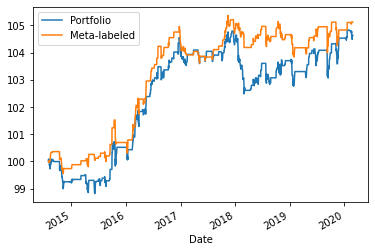

In [ ]:
meta_test_full.plot(y=['Portfolio', 'Meta-labeled'])